<a href="https://colab.research.google.com/github/BillWorstell/derenzo_phantom/blob/master/CallDiffDRR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate 3D homogeneous projections from (Euclidean) volume images of a derenzo_phantom

In [1]:
#Install os and sys, mount drive
import os
import sys
from google.colab import drive
#drive.mount('/content/drive')

!pip install icecream
from icecream import ic

import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpp

In [2]:
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=d8d68f9639ad9547a8564e5f49490bc7e901a01ce7567e38be4cf06f2bb251bd
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=e4361f484ebccc6b8a5aedb37a4b772e58d5488a781813cbbbae5f4d1b6504b6
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 156.4 MB/s eta 0:00:00


# Load data

#Mount google drive and connect to output data path

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Load translations and rotations of phantom

In [4]:
RunTranslate=np.load('/content/gdrive/MyDrive/data/derenzo_phantom/RunTranslate.npy')
ic(RunTranslate.shape)
NRuns=RunTranslate.shape[0]
ic(NRuns)

RunRotate=np.load('/content/gdrive/MyDrive/data/derenzo_phantom/RunRotate.npy')
ic(RunRotate.shape)
NRuns=RunRotate.shape[0]
ic(NRuns)

ic| RunTranslate.shape: (1, 3)
ic| NRuns: 1
ic| RunRotate.shape: (1, 3)
ic| NRuns: 1


1

##Load ground truth volumes orthogonal projections

ic| iEvent: 0


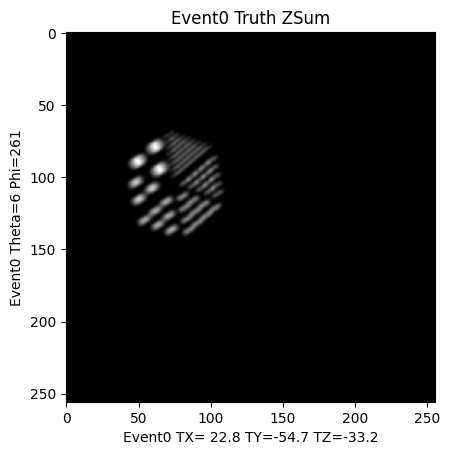

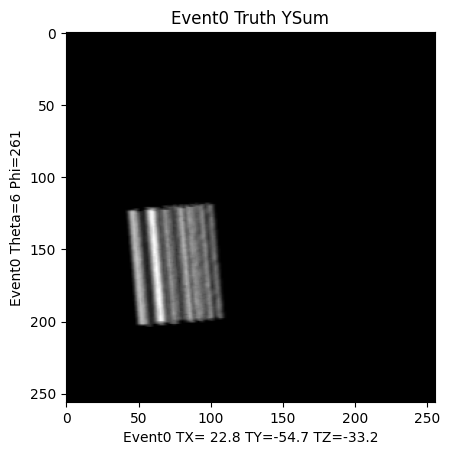

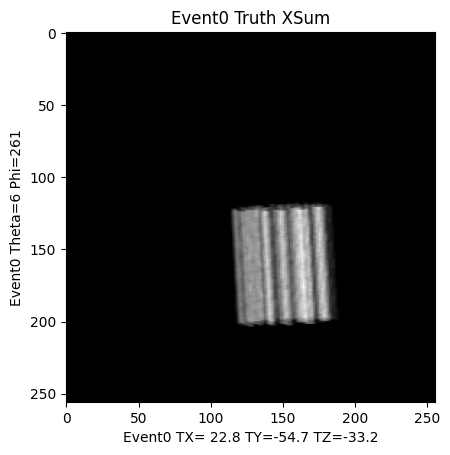

In [5]:
NEvents=1

for iEvent in range(0,NEvents):
  ic(iEvent)
  thisTruth=torch.load(f'/content/gdrive/MyDrive/data/derenzo_phantom/truth_{iEvent}.pt')
  Truth=thisTruth.numpy()
  Truth_Mod0_ZSum=torch.sum(thisTruth,dim=3).numpy()
  Truth_Mod0_YSum=torch.sum(thisTruth,dim=2).numpy()
  Truth_Mod0_XSum=torch.sum(thisTruth,dim=1).numpy()

  TX=RunTranslate[iEvent,0]
  TY=RunTranslate[iEvent,1]
  TZ=RunTranslate[iEvent,2]
  PsiDeg=(180./np.pi)*RunRotate[iEvent,0]
  ThetaDeg=(180./np.pi)*RunRotate[iEvent,1]
  PhiDeg=(180./np.pi)*RunRotate[iEvent,2]

  plt.imshow(np.flipud(Truth_Mod0_ZSum.T),cmap='gray')
  plt.title(f'Event{iEvent} Truth ZSum')
  plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
  plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
  plt.show()

  plt.imshow(np.flipud(Truth_Mod0_YSum.T),cmap='gray')
  plt.title(f'Event{iEvent} Truth YSum')
  plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
  plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
  plt.show()

  plt.imshow(np.flipud(Truth_Mod0_XSum.T),cmap='gray')
  plt.title(f'Event{iEvent} Truth XSum')
  plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
  plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
  plt.show()


#Get Multi-pinhole SPECT System Geometry

In [6]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/SPECTGeometry/'

Mounted at /content/drive


In [7]:
!ls -ltr /content/drive/MyDrive/SPECTGeometry/

total 1223
-rw------- 1 root root 461819 Dec 19 14:27 MDSL.excel80M10RFR.cut-plate.007.150roi.2.30pin.105ellipse.fix.xlsx
-rw------- 1 root root 790185 Dec 22 19:19 MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx


Install openpyxl using pip

In [8]:
pip install openpyxl

https://openpyxl.readthedocs.io/en/stable/tutorial.html#loading-from-a-file

In [9]:
from openpyxl import load_workbook
wb = load_workbook(filename = '/content/drive/MyDrive/SPECTGeometry/MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx',data_only=True)

loop through worksheets

In [10]:
for sheet in wb:
...     print(sheet.title)

Main
Coordinates
MDSL cloud import
Theta
Values
Design Table


Go to Coordinates Worksheet

In [11]:
wb.active = 1
print(wb.active.title)
ws = wb.active

Coordinates


X,Y,Z Coordinates at the center of each pinhole

In [12]:
ic(ws.cell(2,7).value)
XP=np.zeros(80)
YP=np.zeros(80)
ZP=np.zeros(80)
for i in range(3,83):
  XP[i-3]=(ws.cell(i,2).value)
  YP[i-3]=(ws.cell(i,3).value)
  ZP[i-3]=(ws.cell(i,4).value)

ic(XP[0])
ic(YP[0])
ic(ZP[0])

ic| ws.cell(2,7).value: 'length of collimator'
ic| XP[0]: 277.002
ic| YP[0]: 70.37124
ic| ZP[0]: -70.0363


-70.0363

Length of Collimator

In [13]:
ic(ws.cell(2,7).value)
lcoll=np.zeros(80)
for i in range(3,83):
  lcoll[i-3]=(ws.cell(i,7).value)

ic| ws.cell(2,7).value: 'length of collimator'


Choose vsdr = 5 * length of collimator, so by similar triangles

(2*5*lcoll)=source to virtual detector, or 10X

source to virtual detector is 10X size of actual detector

Size of detector at end of collimator is ~50mm

This implies dx * NX = 10 * 50mm ~ 500mm

dx ~ 500/256 ~2mm

    height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.0,  # Pixel spacing (in mm)


In [14]:
vsdr=5.*lcoll

alpha: Azimuthal angle (radians)

In [15]:
ic(ws.cell(2,22).value)
alpha=np.zeros(80)
for i in range(3,83):
  alpha[i-3]=(ws.cell(i,22).value)

ic| ws.cell(2,22).value: 'pinhole azimuth (radians)'


beta = altitude (radians)

In [16]:
ic(ws.cell(2,23).value)
beta=np.zeros(80)
for i in range(3,83):
  beta[i-3]=(ws.cell(i,23).value)

ic| ws.cell(2,23).value: 'pinhole elevation (radians)'


#make meshgrid from volume and spacing

In [17]:
#volume, spacing = load_example_ct()
volume=np.zeros([256,256,256])
spacing=[1.0, 1.0, 1.0]
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx, by, bz)
ic(volume.shape)
ic(spacing)

ic| bx: tensor(128.), by: tensor(128.), bz: tensor(128.)
ic| volume.shape: (256, 256, 256)
ic| spacing: [1.0, 1.0, 1.0]


[1.0, 1.0, 1.0]

Get lab frame coordinates for voxels in volume

In [18]:
xlinspace=np.linspace(-128*spacing[0], 128*spacing[0], 256)
ylinspace=np.linspace(-128*spacing[1], 128*spacing[1], 256)
zlinspace=np.linspace(-128*spacing[2], 128*spacing[2], 256)
xgrid,ygrid,zgrid = np.meshgrid(xlinspace, ylinspace,zlinspace)
xgrid=xgrid.flatten()
ygrid=ygrid.flatten()
zgrid=zgrid.flatten()

#Define camera[0] using PyTorch3D methods

Import methods from pytorch3d

In [19]:
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    PerspectiveCameras, OrthographicCameras, FoVOrthographicCameras,
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

# Map from k-depth extended projection image 3D tensor to 3d volume

#Mount google drive and connect to output data path

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Look around data area

In [21]:
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/truth_0.pt
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/Projections_0.pt
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon96_0.pt
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon256_0.pt
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/RunTranslate.npy
!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom/RunRotate.npy

-rw------- 1 root root 67110044 Feb  7 20:51 /content/gdrive/MyDrive/data/derenzo_phantom/truth_0.pt
-rw------- 1 root root 25167034 Feb  7 20:51 /content/gdrive/MyDrive/data/derenzo_phantom/Projections_0.pt
-rw------- 1 root root 35783866 Feb  7 20:51 /content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon96_0.pt
-rw------- 1 root root 95421631 Feb  7 20:51 /content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon256_0.pt
-rw------- 1 root root 152 Feb  7 20:52 /content/gdrive/MyDrive/data/derenzo_phantom/RunTranslate.npy
-rw------- 1 root root 152 Feb  7 20:52 /content/gdrive/MyDrive/data/derenzo_phantom/RunRotate.npy


# Set up projective geometry for comparison with diffDRR as called earlier by iDerenzoRandomTomograph.ipynb

Length of Collimator

In [23]:
ic(ws.cell(2,7).value)
lcoll=np.zeros(80)
for i in range(3,83):
  lcoll[i-3]=(ws.cell(i,7).value)

ic| ws.cell(2,7).value: 'length of collimator'


##Get DiffDRR version from github

Use the version of DiffDRR posted on github

Git clone from github publib open source code to colab working directory

See https://stackoverflow.com/questions/50850216/google-colab-install-from-github-glrm

In [24]:
#!pip install 'git+https://github.com/BillWorstell/DiffDRR.git'
!pip install 'git+https://github.com/eigenvivek/DiffDRR.git'

  Cloning https://github.com/eigenvivek/DiffDRR.git to /tmp/pip-req-build-tvk1eiw7
  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/DiffDRR.git /tmp/pip-req-build-tvk1eiw7
  Resolved https://github.com/eigenvivek/DiffDRR.git to commit 0fd1bd4199824645215d08f9f9371e29febaace7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.8/740.8 kB 65.2 MB/s eta 0:00

Import diffDRR modules

In [25]:
from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.pose import RigidTransform
from diffdrr.pose import convert

import euler_angles_to_matrix

In [27]:
#volume, spacing = load_example_ct()
#volume=np.zeros([256,256,256])
spacing=[1.0, 1.0, 1.0]
ic(spacing)

for iRun in range(0,NRuns):
  thisTruth=torch.load(f'/content/gdrive/MyDrive/data/derenzo_phantom/truth_{iEvent}.pt')
  volume = torch.squeeze(thisTruth)
  ic(volume.shape)
  #
  for imod in range(0,2):
    ############################
    # Generate DRRs
    ############################
    #
    #| cuda
    # Read in the volume and get the isocenter
    bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
    # Initialize the DRR module for generating synthetic X-rays
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Collect Projections over all modules
    #Projections=torch.zeros([1,96,256,256])

    ic(iRun)
    drr = DRR(
      volume,  # The CT volume as a numpy array
      spacing,  # Voxel dimensions of the CT
      sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
      height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
      delx=2.0,  # Pixel spacing (in mm)
    ).to(device)

    # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

    pose = convert(rotations, translations, parameterization="euler_angles", convention="ZYX")
    source, rays = drr.detector(pose)
    ic(source.shape)
    ic(source)
    ic(rays.shape)

    source_ = source.detach().cpu()
    rays_ = rays.permute(2, 0, 1).detach().cpu()

    if(imod==0):
      Projection_mod0=torch.squeeze(img).cpu().numpy()
    if(imod==1):
      Projection_mod1=torch.squeeze(img).cpu().numpy()


ic| spacing: [1.0, 1.0, 1.0]
ic| volume.shape: torch.Size([256, 256, 256])
ic| iRun: 0
/usr/local/lib/python3.10/dist-packages/diffdrr/drr.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("volume", torch.tensor(volume).flip([0]))
ic| source.shape: torch.Size([1, 1, 3])
ic| source: tensor([[[547.2357, 234.5051, 233.9982]]], device='cuda:0')
ic| rays.shape: torch.Size([1, 65536, 3])
ic| iRun: 0
ic| source.shape: torch.Size([1, 1, 3])
ic| source: tensor([[[493.6746, 289.4873, 233.7808]]], device='cuda:0')
ic| rays.shape: torch.Size([1, 65536, 3])


Display Event0 Mod0 Projection

ic| Projection_mod0.shape: (256, 256)


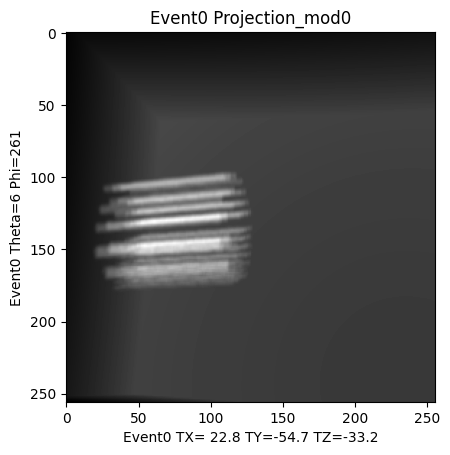

In [28]:
ic(Projection_mod0.shape)
plt.imshow(np.flipud(Projection_mod0.T),cmap='gray')

#  ThisAspect=24/256
#  plt.imshow(np.flipud(eventProjections_2DZSumRow2.T),cmap='gray',aspect=ThisAspect)
plt.title(f'Event{iEvent} Projection_mod0')
plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
plt.show()


https://vivekg.dev/DiffDRR/tutorials/optimizers.html

/usr/local/lib/python3.10/dist-packages/diffdrr/drr.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("volume", torch.tensor(volume).flip([0]))


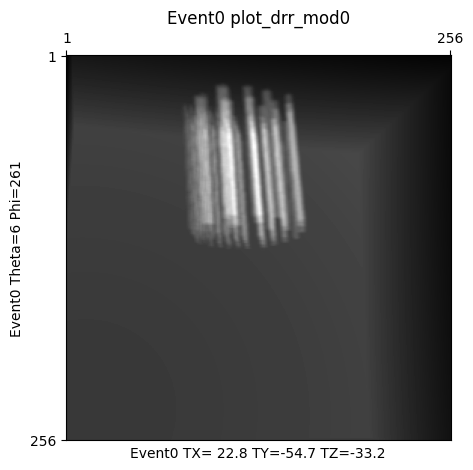

In [30]:
for imod in range(0,1):
    drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
    ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

    if(imod==0):
      Projection_mod0=torch.squeeze(img).cpu().numpy()
    if(imod==1):
      Projection_mod1=torch.squeeze(img).cpu().numpy()
    plot_drr(img)

    plt.title(f'Event{iEvent} plot_drr_mod0')
    plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
    plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
    plt.show()

From https://tutorial.pyvista.org/getting-started.html

In [31]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
!sudo apt install libgl1-mesa-glx xvfb

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [33]:
import pyvista

pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

From https://vivekg.dev/DiffDRR/tutorials/visualization.html


ic| rotations: tensor([[ 0.2488, -0.2403,  1.5708]], device='cuda:0')
ic| principal_ray: PolyData (0x7d843c14e7a0)
                     N Cells:    1
                     N Points:   2
                     N Strips:   0
                     X Bounds:   -2.912e+02, 5.472e+02
                     Y Bounds:   2.149e+01, 2.345e+02
                     Z Bounds:   2.200e+01, 2.340e+02
                     N Arrays:   2


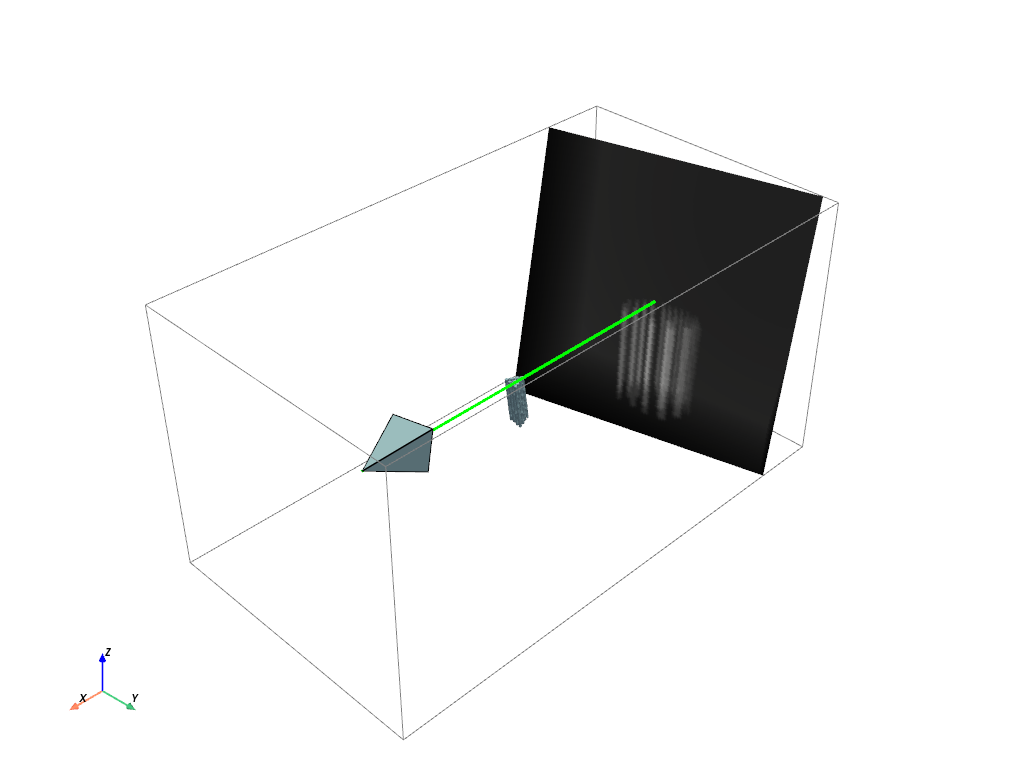

In [41]:
from diffdrr.visualization import drr_to_mesh, img_to_mesh

for imod in range(0,1):
  drr = DRR(
  volume,  # The CT volume as a numpy array
  spacing,  # Voxel dimensions of the CT
  sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
  height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
  delx=2.0,  # Pixel spacing (in mm)
  ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
  rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
  ic(rotations)
  translations = torch.tensor([[bx, by, bz]], device=device)
  img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

  # Make a mesh from the CT volume
  ct = drr_to_mesh(drr, "surface_nets", threshold=0.00001, verbose=False)
  #ct = drr_to_mesh(drr, "marching_cubes", threshold=0.0001, verbose=False)
  # Make the plot
  plotter = pyvista.Plotter()
  plotter.add_mesh(ct)
  # Make a mesh from the camera and detector plane
  pose = convert(rotations, translations, parameterization="euler_angles", convention="ZYX")
  camera, detector, texture, principal_ray = img_to_mesh(drr, pose)
  ic(principal_ray)

  # Make the plot
  plotter = pyvista.Plotter()
  plotter.add_mesh(ct)
  plotter.add_mesh(camera, show_edges=True, line_width=1.5)
  plotter.add_mesh(principal_ray, color="lime", line_width=3)
  plotter.add_mesh(detector, texture=texture)

  # Render the plot
  plotter.add_axes()
  plotter.add_bounding_box()
  plotter.show()
  #plotter.show(jupyter_backend="server")  # If running Jupyter remotely


Event0 mod11

/usr/local/lib/python3.10/dist-packages/diffdrr/drr.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("volume", torch.tensor(volume).flip([0]))


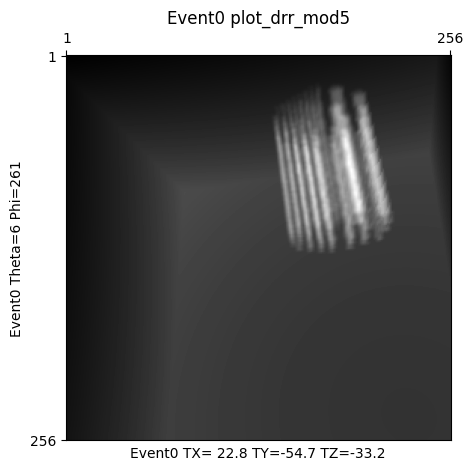

In [35]:
  for imod in range(5,6):

    drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
    ).to(device)

    # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

    if(imod==0):
      Projection_mod0=torch.squeeze(img).numpy()
    if(imod==1):
      Projection_mod1=torch.squeeze(img).numpy()
    plot_drr(img)

    plt.title(f'Event{iEvent} plot_drr_mod5')
    plt.xlabel(f'Event{iEvent} TX={TX:5.1f} TY={TY:5.1f} TZ={TZ:5.1f}')
    plt.ylabel(f'Event{iEvent} Theta={ThetaDeg:.0f} Phi={PhiDeg:.0f}')
    plt.show()

ic| rotations: tensor([[ 1.2618, -0.3673,  1.5708]], device='cuda:0')
ic| principal_ray: PolyData (0x7d8486625240)
                     N Cells:    1
                     N Points:   2
                     N Strips:   0
                     X Bounds:   4.573e+01, 2.103e+02
                     Y Bounds:   -1.297e+02, 3.857e+02
                     Z Bounds:   2.391e+01, 2.321e+02
                     N Arrays:   2


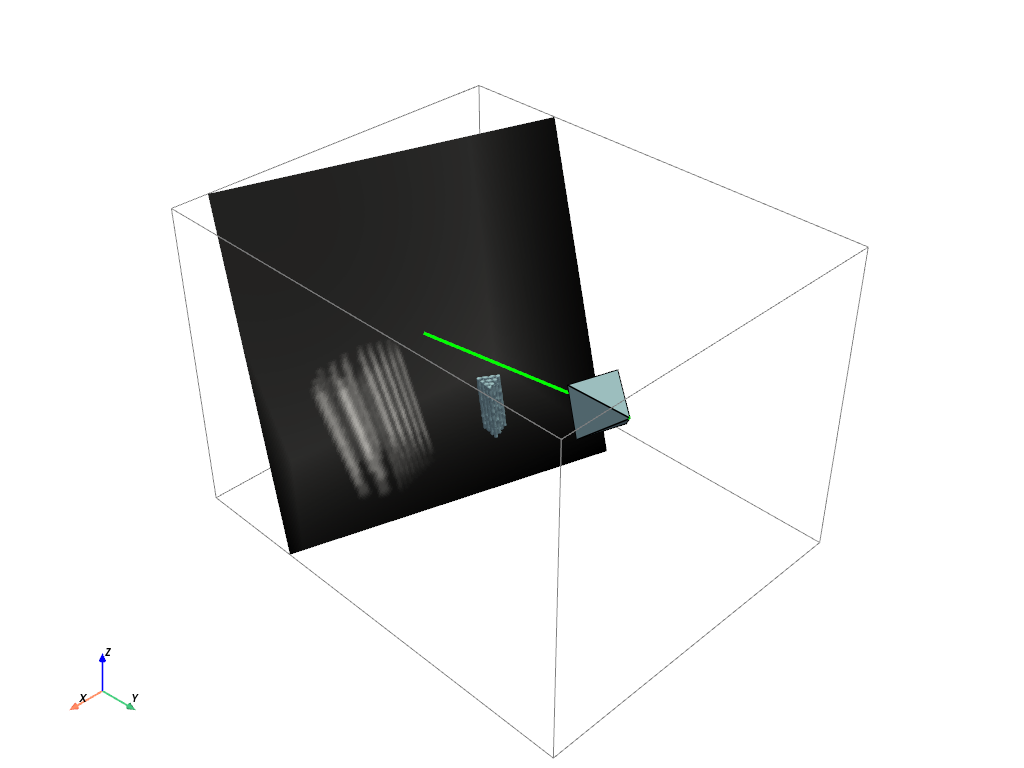

In [36]:
for imod in range(5,6):
  drr = DRR(
  volume,  # The CT volume as a numpy array
  spacing,  # Voxel dimensions of the CT
  sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
  height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
  delx=2.0,  # Pixel spacing (in mm)
  ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
  rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
  ic(rotations)
  translations = torch.tensor([[bx, by, bz]], device=device)
  img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

  # Make a mesh from the CT volume
  ct = drr_to_mesh(drr, "surface_nets", threshold=0.00001, verbose=False)

  # Make the plot
  plotter = pyvista.Plotter()
  plotter.add_mesh(ct)
    # Make a mesh from the camera and detector plane
  pose = convert(rotations, translations, parameterization="euler_angles", convention="ZYX")
  camera, detector, texture, principal_ray = img_to_mesh(drr, pose)
  ic(principal_ray)

  # Make the plot
  plotter = pyvista.Plotter()
  plotter.add_mesh(ct)
  plotter.add_mesh(camera, show_edges=True, line_width=1.5)
  plotter.add_mesh(principal_ray, color="lime", line_width=3)
  plotter.add_mesh(detector, texture=texture)

  # Render the plot
  plotter.add_axes()
  plotter.add_bounding_box()
  plotter.show()